In [1]:
import numpy as npp
import matplotlib.pyplot as plt
from IPython.core.display import HTML
#this css file can be downloaded from [David's repo](https://github.com/ketch/PseudoSpectralPython/blob/master/custom.css)
#Then set the address of css file as per your address of file
#Following two commands are not needed for calculations.
css_file = '/Users/rajvanmp/Downloads/custom.css'

#HTML(open(css_file, "r").read())

Here we use the example from [David Ketcheson's course](https://github.com/ketch/PseudoSpectralPython/blob/master/PSPython_05-ImEx-RK.ipynb). We copy the code from there and then modify the time loop to use the GPE class. This illustrates the basic use of GPE classes defined in this repo.

In [2]:
#Import the needed classes.
#GPE_Scalar_Field is the class for representing the GP-like fields(as defined in repo home)
import sys

sys.path.append('../')
from GPE import GPE_scalar_field

#ImEx is just a class for holding no. of stages and Butcher Tableau for ImEx methods
from GPE import ImEx

In [3]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML
font = {'size'   : 15}
matplotlib.rc('font', **font)

fft = np.fft.fft
ifft = np.fft.ifft

def plot_solution(frames, uuhat, x, tt, xi):
    fig = plt.figure(figsize=(12,8))
    axes = fig.add_subplot(211)
    axes2 = fig.add_subplot(212)
    line, = axes.plot(x,frames[0],lw=3)
    line2, = axes2.semilogy(xi,np.abs(np.fft.fft(frames[0])))
    xi_max = np.max(np.abs(xi))
    axes2.semilogy([xi_max/2.,xi_max/2.],[1.e-6,4e8],'--r')
    axes2.semilogy([-xi_max/2.,-xi_max/2.],[1.e-8,4e10],'--r')
    axes.set_xlabel(r'$x$',fontsize=30)
    axes2.set_xlabel(r'$\xi$',fontsize=30)
    plt.tight_layout()
    plt.close()

    def plot_frame(i):
        line.set_data(x,frames[i])
        power_spectrum = np.abs(uuhat[i])**2
        line2.set_data(np.sort(xi),power_spectrum[np.argsort(xi)])
        axes.set_title('t= %.2e' % tt[i])
        axes.set_xlim((-np.pi,np.pi))
        axes.set_ylim((-200,3000))

    anim = matplotlib.animation.FuncAnimation(fig, plot_frame,
                                              frames=len(frames), interval=100,
                                              repeat=False)
    return HTML(anim.to_jshtml())

\begin{equation}
\frac{\partial \psi}{\partial t} = rhs\_f + im\_rhs
\end{equation}
i.e. all the contributions for explicit method are given by rhs_f in following code while im_rhs calculates implicitly treated term's contribution. For example in KdV case:
\begin{equation}
im\_rhs = -u_{xxx}
\end{equation}
\begin{equation}
rhs\_f = -uu_{x}
\end{equation}

In [4]:
#Example KdV

# Higueras (17)
A    = np.array([[0,0,0],[5/6.,0,0],[11/24,11/24,0]])
Ahat = np.array([[2./11,0,0],[205/462.,2./11,0],[2033/4620,21/110,2/11]])
b = np.array([24/55.,1./5,4./11])
bhat = b

imx = ImEx(3,Ahat,A,bhat,b)



#Defining right hand side for the PDE, which contains everything EXCEPT laplacian term. If you are using filtering..
#..filtr should be passed here as an argument as shown

def rhs_f(u, xi, filtr):
    # Evaluate only the non-stiff nonlinear term
    uhat = np.fft.fft(u)
    return -u*np.real(np.fft.ifft(1j*xi*uhat*filtr))

#Please note that following function doesn't use filtr at all, but for the convenience of supporting...
#..functions with varying length of arguement list, we just pass same argument list (after 1st argument) to..
#..both im_rhs and rhs_f
#So, the format is: we pass (sub_stage_no,arg_list) to class method ::update_K(sub_stage_no,arg_method) which...
#..then passes (psi_k,arg_list) to rhs_f(psi_k,arg_list) and (ft_psi_k,arg_list) to im_rhs(ft_psi_k,arg_list)..
#..where psi_k is temporary sub-stage solution while ft_psi_k is Fourier Transform of same.

def im_rhs(psi_ft,xi,filtr):
    psi_ft = psi_ft*(1j*xi**3)
    return(np.fft.ifft(psi_ft))


def solve_KdV_ImEx2(m,dt,use_filter=True):
    L = 2*np.pi
    x = np.arange(-m/2,m/2)*(L/m)
    xi = np.fft.fftfreq(m)*m*2*np.pi/L

    u = 1500*np.exp(-10*(x+2)**2)
    uc = np.zeros_like(u)
    uin = u+1j*uc
    print(type(uin),uin.shape,uin.dtype)
    tmax = 0.05

    uhat2 = np.abs(np.fft.fft(u))

    num_plots = 50
    nplt = np.floor((tmax/num_plots)/dt)
    nmax = int(round(tmax/dt))

    frames = [u.copy()]
    tt = [0]
    uuhat = [uhat2]

    filtr = np.ones_like(xi)
    
    #Define psi as an instance of class GPE_scalar_field
    #1st argument sets the space-dim of problem. In this 
    #case of 1-d problem, it is 1. Next argument(m here)
    #gives no. of points in space, then we pass im_rhs
    #and rhs_f functions followed by ImEx object. Last 
    #argument passes a scalar array uin which is initial
    #condition at t=0. Note that it as passed as a complex array
    
    psi = GPE_scalar_field(1,m,im_rhs,rhs_f,imx,uin,relax=True)
    lmbda = -xi**3
    
    if use_filter:
        xi_max = np.max(np.abs(xi))
        filtr[np.where(np.abs(xi)>xi_max*2./3)] = 0.
        
    t = 0.0
    n=0
        
    while (t<=tmax):
        #for each stage
        for k in range(imx.s):
            
            #update summation for input to FFT for calc. implicit contribution
            psi.update_stage_sum(k,dt)
            
            #Do fft,mulitply by needed functions and do inverse fft
            psi.do_fft(k,lmbda,dt)
            
            #update im_K and ex_K i.e. stage contributions
            psi.update_K(k,xi,filtr)
            
        #Sum over stage contributions
        psi.sum_contributions(dt)
        
        
        t = t+ psi.rel_gamma*dt
        n=n+1
        if np.mod(n,nplt) == 0:
            frames.append(psi.psi.real)
            tt.append(t)
            uhat2 = np.abs(np.fft.fft(psi.psi.real))
            uuhat.append(uhat2)


       
    return frames, uuhat, x, tt, xi

In [ ]:
m = 256
umax = 3000
dt =1*1.2/(m/2)/umax
use_filter=False

frames, uuhat, x, tt, xi = solve_KdV_ImEx2(m,dt,use_filter)

In [8]:
(1.000028908237041-1.0)/(1.0000003338503385-1.0)

96.36079015188479

In [57]:
plot_solution(frames, uuhat, x, tt, xi)

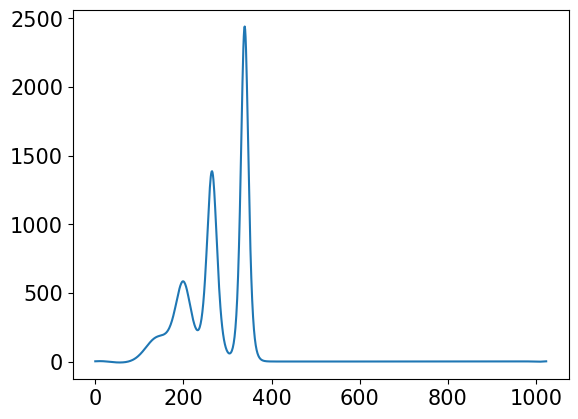

In [53]:
plt.plot(frames[1])

In [22]:
len(frames)

51